# Projeto Marinha do Brasil

## Laboratório de Processamento de Sinais - UFRJ

### Autor: Vinícius dos Santos Mello <viniciusdsmello@poli.ufrj.br>

In [1]:
import os
import sys
import time
sys.path.insert(0,'..')

from noveltyDetectionConfig import CONFIG
import numpy as np
import itertools
import multiprocessing

from SAENoveltyDetectionAnalysis import SAENoveltyDetectionAnalysis

num_processes = multiprocessing.cpu_count()

analysis_name = 'StackedAutoEncoder'

# Enviroment variables
data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']

analysis = SAENoveltyDetectionAnalysis(analysis_name="StackedAutoEncoder", development_flag = False, development_events=400, n_windows=1,
                                       loadData=True)
all_data, all_trgt, trgt_sparse = analysis.getData()

Using TensorFlow backend.


[+] Time to read data file: 1.33653187752 seconds
Qtd event of A is 12939
Qtd event of B is 29352
Qtd event of C is 11510
Qtd event of D is 23760

Biggest class is B with 29352 events


#### Load the train parameters file

In [2]:
analysis.setTrainParameters(n_inits=2,
                            hidden_activation='tanh',
                            output_activation='linear',
                            n_epochs=300,
                            n_folds=8,
                            patience=30,
                            batch_size=256,
                            verbose=False,
                            norm='mapstd',
                            optmizerAlgorithm='Adam',
                            metrics=['accuracy'],
                            loss='mean_squared_error')
print ("\nResults path: {}\n".format( analysis.getBaseResultsPath()))

trn_params = analysis.trn_params

for ikey in trn_params.params:
    print("{}: {}".format(ikey, trn_params.params[ikey]))

Reading from /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/8_folds_cross_validation.jbl

Results path: /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/Adam_optmizer/tanh_sae_hidden_activation/linear_sae_output_actvation/softmax_classifier_output_activation/2_init_8_folds_mapstd_norm_300_epochs_256_batch_size_accuracy_metric_mean_squared_error_loss

beta_1: 0.9
metrics: ['accuracy']
beta_2: 0.999
verbose: False
loss: mean_squared_error
nesterov: True
folds: 8
learning_rate: 0.001
n_inits: 2
batch_size: 256
n_epochs: 300
train_verbose: False
patience: 30
learning_decay: 1e-06
momentum: 0.3
classifier_output_actvation: softmax
epsilon: 1e-08
optmizerAlgorithm: Adam
output_activation: linear
hidden_activation: tanh
norm: mapstd


#### Initialize objects of StackedAutoEncoder class for all models with its corresponding novelty class

In [4]:
analysis.createSAEModels()
SAE = analysis.getSAEModels()

#### Perform the training of the model

In [25]:
from Functions.lossWeights import getGradientWeights

getGradientWeights(trgt)

{0.0: 0.3921368220223494, 1.0: 1.0, 2.0: 0.48442760942760943}

In [ ]:
trn_data = analysis.trn_data
trn_trgt = analysis.trn_trgt
trn_trgt_sparse = analysis.trn_trgt_sparse

inovelty = 0

data=trn_data[inovelty]
trgt=trn_trgt[inovelty]

SAE[inovelty].trainClassifier(data  = data,
                              trgt  = trgt,
                              ifold = 0,
                              hidden_neurons = [100],
                              layer = 1,
                              regularizer=None,
                              regularizer_param="")

# def train(fold):
#         SAE[inovelty].trainClassifier(data  = data,
#                                       trgt  = trgt,
#                                       ifold = fold,
#                                       hidden_neurons = hidden_neurons,
#                                       layer = layer,
#                                       regularizer=regularizer,
#                                       regularizer_param=regularizer_param)
#         p = multiprocessing.Pool(processes=num_processes)

#         results = p.map(train, range(analysis.n_folds))

#         p.close()
#         p.join()

In [11]:
for inovelty in range(len(analysis.class_labels[0])):
    startTime = time.time()
    analysis.train(layer=1,
                   inovelty=inovelty,
                   fineTuning=True,
                   trainingType="neuronSweep", #foldSweep, neuronSweep, normal
                   hidden_neurons=[400],
                   neurons_variation_step=100,
                   numThreads=8,
                   regularizer=None,
                   regularizer_param=0)
    print "The training of the model for novelty {0} took {1} seconds to be performed\n".format(analysis.class_labels[inovelty], time.time() - startTime)

python modelTrain.py --layer 1 --novelty 0 --finetunning 1 --threads 8 --type foldSweep --hiddenNeurons 400 --neuronsVariationStep 25
The training of the model for novelty A took 8.46654486656 seconds to be performed



# Pre-training analysis

### Regularization impact

In [5]:
# Neuron variation x KL Divergence

%matplotlib inline 

from sklearn import metrics
from sklearn import preprocessing
from sklearn.externals import joblib
from Functions.StatisticalAnalysis import KLDiv, EstPDF

analysis_name = "regularization_impact_mapstd"
analysis_file = os.path.join(results_path, "StackedAutoEncoder", "AnalysisFiles", analysis_name + ".jbl")    

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

step = 50
neurons_mat = [1] + range(step,hidden_neurons[layer-1]+step,step)
neurons_mat = neurons_mat[:len(neurons_mat)-layer+2]

regularizers = ['l1', 'l2']
regularizer_params = [10**i for i in range(-1,2)]
classes = range(len(analysis.getClassLabels()))
folds = range(analysis.n_folds)

topologies = list(itertools.product(neurons_mat, folds, classes, regularizers, regularizer_params))
results = np.zeros([len(neurons_mat), analysis.n_folds, len(analysis.getClassLabels()), len(regularizers), len(regularizer_params)], dtype=object)

n_bins = 100

def getResults(topology):
    ineuron, ifold, inovelty, regularizer, regularizer_param = topology
    
    print topology
    
    saeModel = SAE[inovelty].getModel(analysis.trn_data[inovelty], analysis.trn_trgt[inovelty],
                                      hidden_neurons=[ineuron],
                                      layer=layer, ifold=ifold,
                                      regularizer=regularizer, regularizer_param=regularizer_param)             

    classifier = SAE[inovelty].loadClassifier(analysis.trn_data[inovelty], analysis.trn_trgt[inovelty],
                                              hidden_neurons=[ineuron],
                                              layer=layer, ifold=ifold,
                                              regularizer=regularizer, regularizer_param=regularizer_param)   

    # Normalize the data used based on the normalization used during the training       

    train_id, test_id = analysis.CVO[inovelty][ifold]  
    # normalize known classes
    if trn_params.params['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif trn_params.params['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
    elif trn_params.params['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[all_trgt!=inovelty][train_id,:])
        
    if trn_params.params['norm'] != 'without':
        knownData = scaler.transform(all_data[all_trgt!=inovelty][test_id,:])
        noveltyData = scaler.transform(all_data[all_trgt==inovelty])
    else: 
        knownData = all_data[all_trgt!=inovelty][test_id,:]
        noveltyData = all_data[all_trgt==inovelty]
        
    outputKnownData = saeModel.predict(knownData)
    outputNoveltyData = saeModel.predict(noveltyData)


    # Compute metrics
    #################### Pre-training step #######################
    # Mean squared error
    mse_known = metrics.mean_squared_error(knownData, outputKnownData)
    mse_novelty = metrics.mean_squared_error(noveltyData, outputNoveltyData)

    # Kullback-leibler divergence
    klKnown = np.zeros([all_data.shape[1]], dtype=object)
    klNovelty = np.zeros([all_data.shape[1]], dtype=object)

    for ifrequency in range(0,all_data.shape[1]):
        # Calculate KL Div for known data reconstruction
        known_data_freq = knownData[:,ifrequency]
        reconstructed_known_data = outputKnownData[:,ifrequency]

        m_bins = np.linspace(known_data_freq.min(), known_data_freq.max(), n_bins)

        klKnown[ifrequency] = KLDiv(known_data_freq.reshape(-1,1), reconstructed_known_data.reshape(-1,1),
                                    bins=m_bins, mode='kernel', kernel='epanechnikov',
                                    kernel_bw=0.1, verbose=False)

        klKnown[ifrequency] = klKnown[ifrequency][0]

        # Calculate KL Div for novelty data reconstruction
        novelty_data_freq = noveltyData[:,ifrequency]
        reconstructed_novelty_data = outputNoveltyData[:,ifrequency]

        m_bins = np.linspace(novelty_data_freq.min(), novelty_data_freq.max(), n_bins)

        klNovelty[ifrequency] = KLDiv(novelty_data_freq.reshape(-1,1), reconstructed_novelty_data.reshape(-1,1),
                               bins=m_bins, mode='kernel', kernel='epanechnikov',
                               kernel_bw=0.1, verbose=False)

        klNovelty[ifrequency] = klNovelty[ifrequency][0]
    #################### Fine-tuning step ########################
    # Accuracy
    
    # Class Effiency
    
    # Trigger
    
    # SP Index

    return ineuron, ifold, inovelty, regularizer, regularizer_param, mse_known, mse_novelty, klKnown, klNovelty
if not os.path.exists(analysis_file):
    # Start Parallel processing

    p = multiprocessing.Pool(processes=num_processes)

    tempResults = np.zeros(len(topologies))
    tempResults = p.map(getResults, topologies)

    p.close()
    p.join()

    for iresult in tempResults:
        ineuron, ifold, inovelty, regularizer, regularizer_param, mse_known, mse_novelty, klKnown, klNovelty = iresult

        results[neurons_mat.index(ineuron),
                ifold,inovelty,
                regularizers.index(regularizer),
                regularizer_params.index(regularizer_param)] = {
                                                               'mse_known': mse_known,
                                                               'mse_novelty': mse_novelty,
                                                               'klKnown': klKnown,
                                                               'klNovelty': klNovelty
                                                               }

                     
    print("Saving file " + analysis_file)
    joblib.dump([results],analysis_file,compress=9)                    
    print("Finished")
else:
    print("Loading file " + analysis_file)
    [results] = joblib.load(analysis_file)        
    print("Finished")

Loading file /home/vinicius.mello/Workspace/SonarAnalysis/Results/NoveltyDetection/StackedAutoEncoder/AnalysisFiles/regularization_impact_mapstd.jbl
Finished


## Mean Squared Error analysis for Pre-training Step with a neuron variation at autoencoder

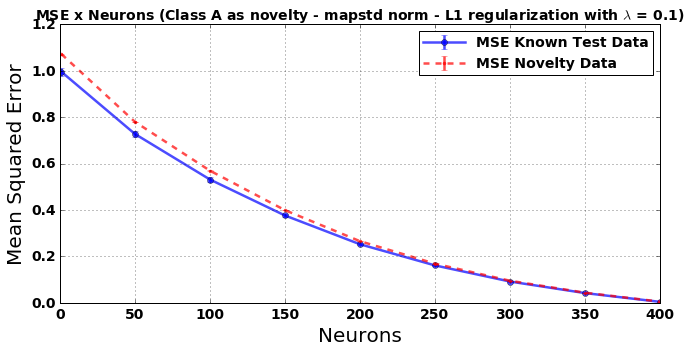

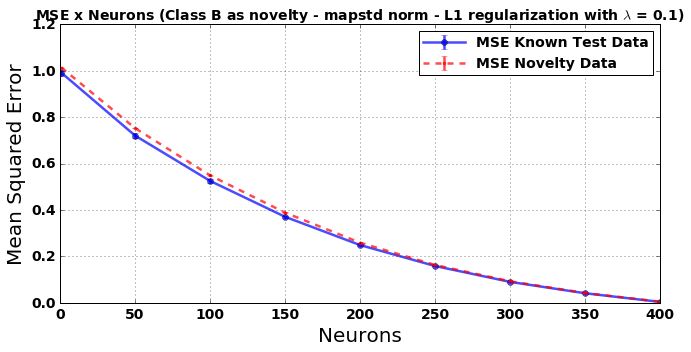

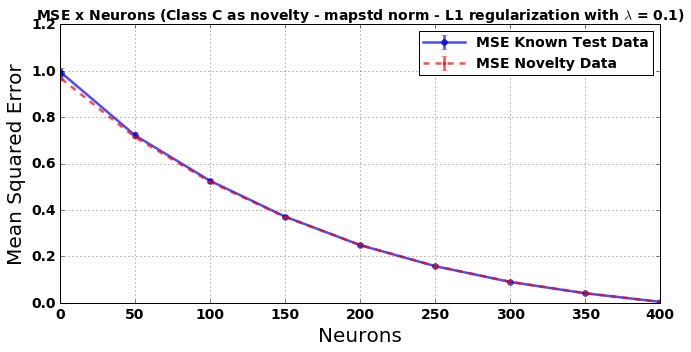

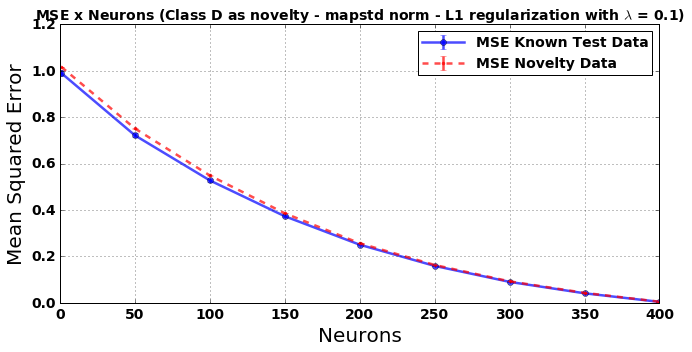

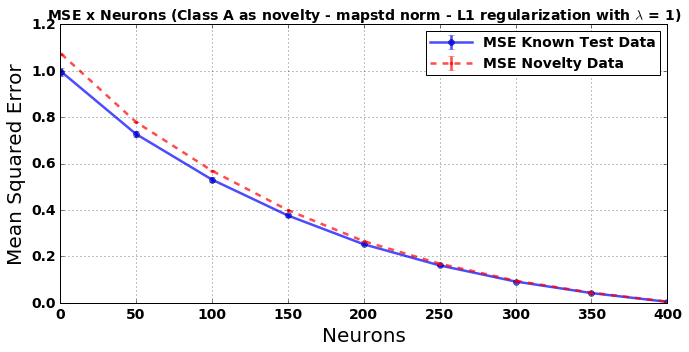

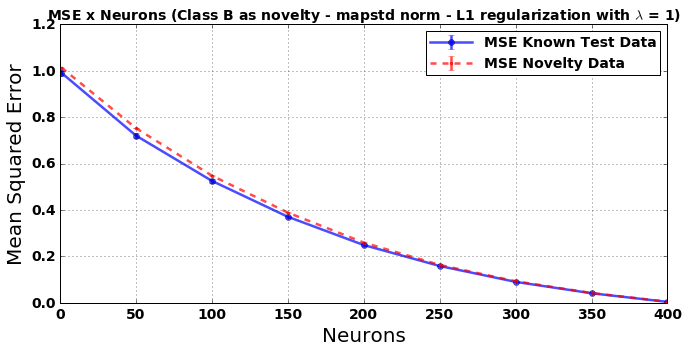

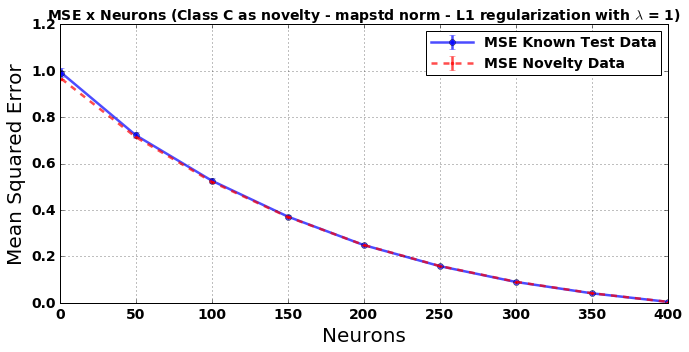

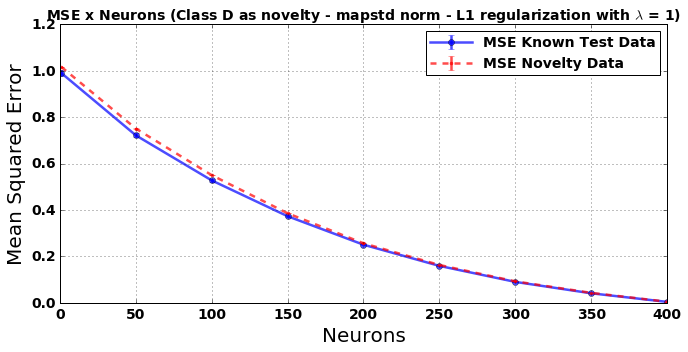

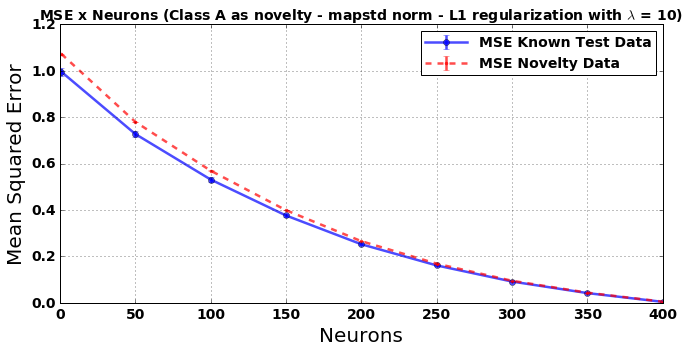

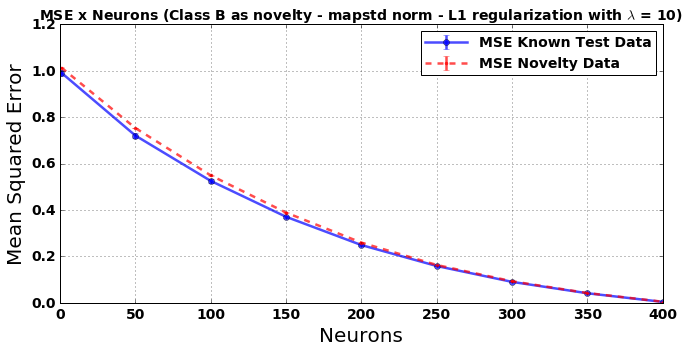

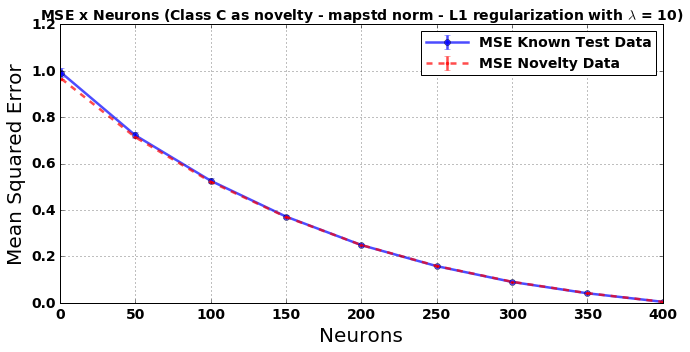

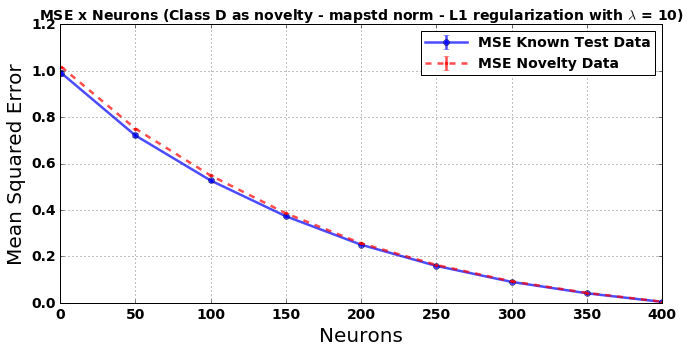

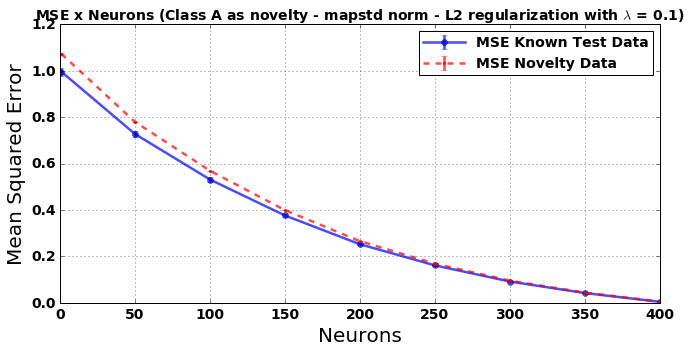

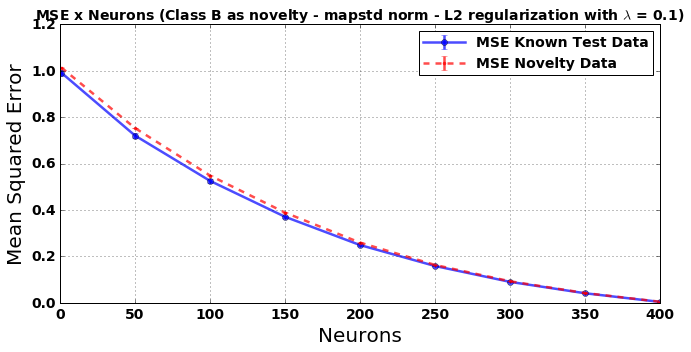

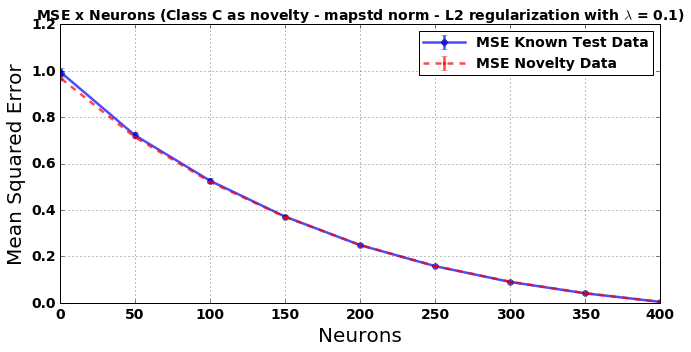

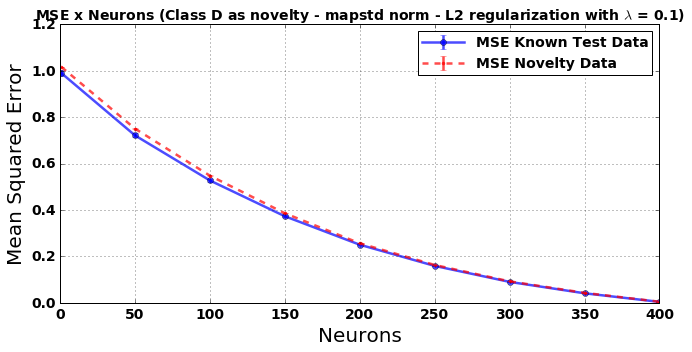

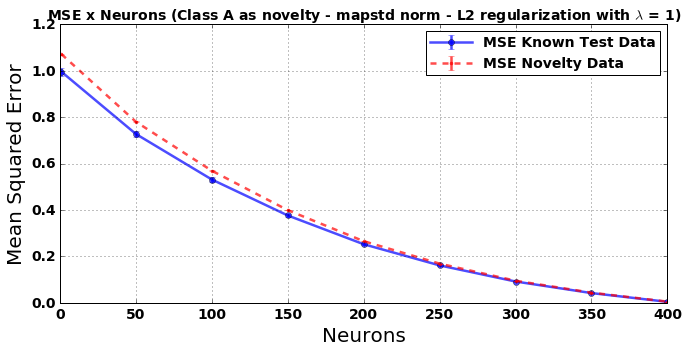

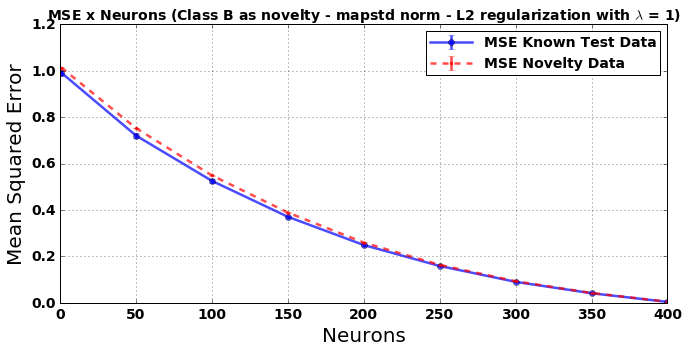

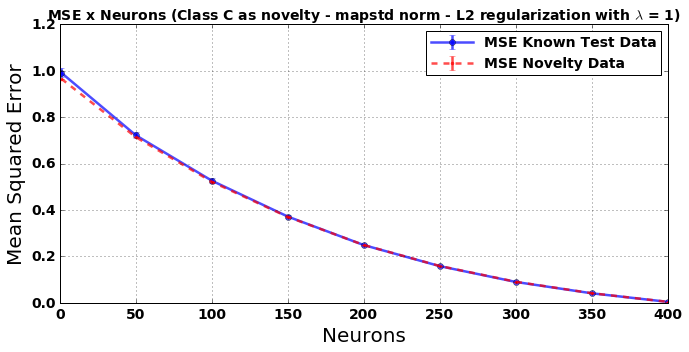

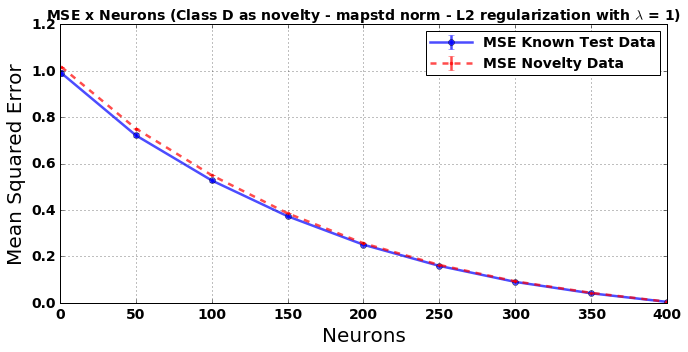

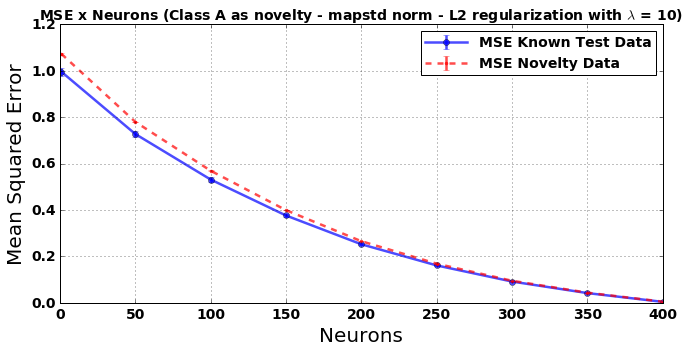

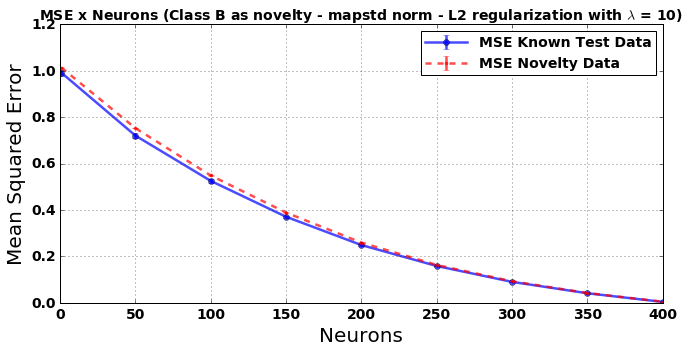

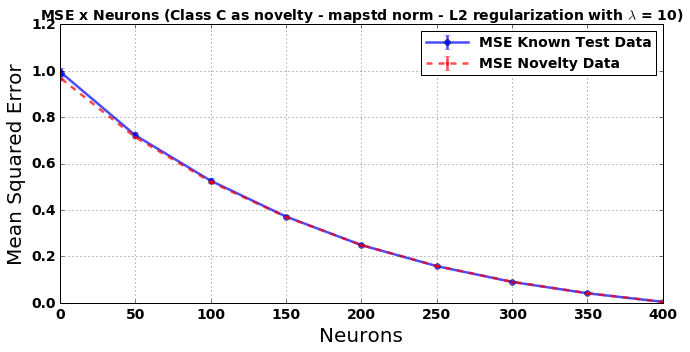

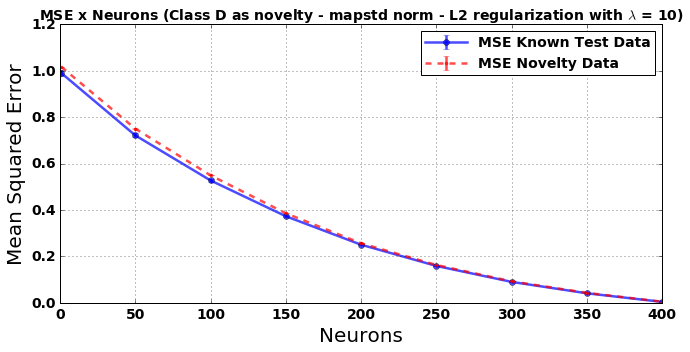

In [60]:
# Neuron variation x KL Divergence
%matplotlib inline 
import matplotlib.pyplot as plt

# Choose layer 
layer = 1

# Choose neurons topology
hidden_neurons = range(400,0,-50) + [2]

# generate analysis data
save_path=results_path

current_analysis = 'mean_squared_error_%i_layer_%i_novelty'%(layer, inovelty)
analysis_str = 'StackedAutoEncoder'
model_prefix_str = 'RawData'

verbose = True

# Plot parameters
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.fontsize'] = 14
m_colors = ['b', 'r', 'g', 'y']
figsize = (10,5)

for regularizer in regularizers:
    for regularizer_param in regularizer_params:
        for inovelty in range(len(analysis.class_labels)):
            # Results
            mse_known = np.zeros([len(neurons_mat), analysis.n_folds])
            mse_novelty = np.zeros([len(neurons_mat), analysis.n_folds])
            for ineuron_index in range(len(neurons_mat)):
                for ifold in range(analysis.n_folds):
                    mse_known[ineuron_index, ifold] = results[ineuron_index, ifold, inovelty,
                                                  regularizers.index(regularizer),
                                                  regularizer_params.index(regularizer_param)]['mse_known']
                    mse_novelty[ineuron_index, ifold] = results[ineuron_index, ifold, inovelty,
                                                  regularizers.index(regularizer),
                                                  regularizer_params.index(regularizer_param)]['mse_novelty']

            # Plot results    
            fig = plt.subplots(figsize=figsize)
            ax = plt.subplot(1,1,1)

            ax.errorbar(neurons_mat, np.mean(mse_known, axis=1),
                        np.std(mse_known, axis=1),fmt='o-',
                        color='b',alpha=0.7,linewidth=2.5,
                        label='MSE Known Test Data')
            ax.errorbar(neurons_mat, np.mean(mse_novelty, axis=1),
                        np.std(mse_novelty, axis=1),fmt='.--',
                        color='r',alpha=0.7,linewidth=2.5,
                        label='MSE Novelty Data')

            ax.set_title('MSE x Neurons (Class {} as novelty - {} norm - {} regularization with $\lambda$ = {})'.format(analysis.class_labels[inovelty],
                                                                                                                        analysis.trn_params.params['norm'],
                                                                                                                        regularizer.upper(), regularizer_param)
                         , fontsize=14, fontweight='bold')
            
            ax.set_ylabel('Mean Squared Error', fontsize=20)
            ax.set_xlabel('Neurons', fontsize=20)
            ax.grid()
            ax.legend()
            plt.tight_layout()

            plt.show()

#Save the figure
# file_name = pict_results_path+'/'+current_analysis+'_%i_novelty_%s_neurons_'%(inovelty,neurons_str)+trn_params.get_params_str()+'.pdf'
# plt.savefig(file_name)

## Receiver Operating Characteristic (ROC) Curve for SP/Trigger with Novelty Detection